In [1]:
using JLD2

In [2]:
ρsdat = 0.0:0.02:1.0;
# threadids = setdiff(1:16,[5,6,8,11,15,16]);
threadids = 1:16;

In [3]:
# @time sim_results = [
#     vcat((jldopen("./results/results_experiment7/experiment7-solution_ending_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];
# @time sim_results = [
#     vcat((jldopen("./results/results_experiment8/experiment8-solution_ending_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];

In [4]:
# @time deriv_sim_results = [
#     vcat((jldopen("./results/results_experiment7/experiment7-solution_ending_derivatives_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];
# @time deriv_sim_results = [
#     vcat((jldopen("./results/results_experiment8/experiment8-solution_ending_derivatives_thread="*string(threadid)*"_rho="*string(ρ)*".jld2")["data"] for threadid in threadids)...)
# for ρ in ρsdat];

In [5]:
# jldsave("./results/results_experiment7/experiment7-results.jld2";sim_results);
# jldsave("./results/experiment8-results.jld2";sim_results);
# jldsave("./results/results_experiment7/experiment7-deriv-results.jld2";deriv_sim_results);
# jldsave("./results/experiment8-deriv-results.jld2";deriv_sim_results);

In [6]:
sim_results = jldopen("./experiment7-results.jld2")["sim_results"];
deriv_sim_results = jldopen("./experiment7-deriv-results.jld2")["deriv_sim_results"];

In [7]:
using Plots, PlotThemes, LaTeXStrings, Statistics, Random; theme(:dao)

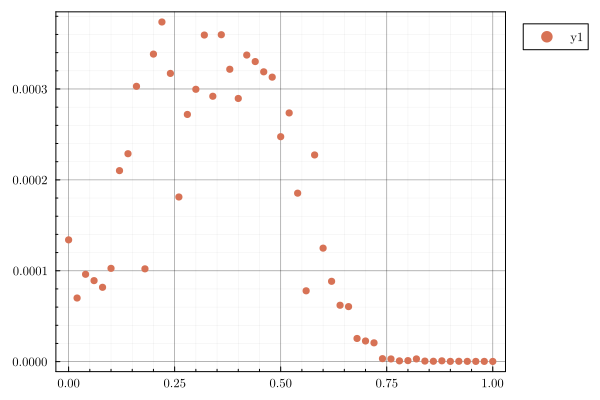

In [8]:
scatter(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)])

In [ ]:
[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)]

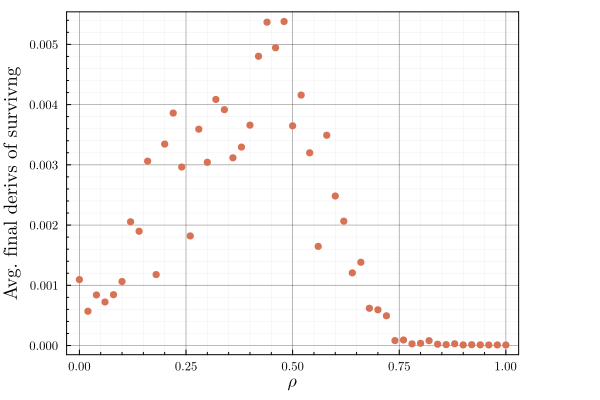

In [9]:
scatter(ρsdat,(Y->mean((X->sum(abs.(X))).(Y))).(deriv_sim_results),label=:none,xlabel=L"\rho",ylabel="Avg. final derivs of survivng")

In [10]:
using SpecialFunctions

Φ(x) = erfc(-x/sqrt(2))/2;
w1(x) = exp(-x^2/2)/sqrt(2π) + x*Φ(x);
w2(x) = x*exp(-x^2/2)/sqrt(2π) + (1+x^2)*Φ(x);

g(eR,μc,m) = μc*eR - m;
κ(eN,μe,K,γ) = K - μe*eN/γ;
σg(qR,σc,σm) = sqrt(σm^2 + σc^2*qR);
σκ(qN,σe,σK,γ) = sqrt(σK^2 + σe^2*qN/γ);
Δκ(eN,qN,μe,σe,K,σK,γ) = κ(eN,μe,K,γ)/σκ(qN,σe,σK,γ);
Δg(eR,qR,μc,σc,m,σm) = g(eR,μc,m)/σg(qR,σc,σm);

ϕNeq(ϕN,eR,qR,μc,σc,m,σm) = ϕN - (Φ(Δg(eR,qR,μc,σc,m,σm)));
ϕReq(ϕR,eN,qN,μe,σe,K,σK,γ) = ϕR - (Φ(Δκ(eN,qN,μe,σe,K,σK,γ)));
νeq(ϕN,ν,χ,σc,σe,K,σK,m,σm,ρ) = ν - (
    -ϕN/(σc*σe*ρ*χ)
);
χeq(ϕR,ν,χ,σc,σe,γ,ρ) = χ - (
    ϕR/(1-ρ*σe*σc*ν/γ)
);
eNeq(χ,eN,eR,qR,μc,σc,σe,m,σm,ρ) = eN - (
    (σg(qR,σc,σm)/(σc*σe*ρ*χ))*w1(Δg(eR,qR,μc,σc,m,σm))
);
eReq(ν,eN,eR,qN,σc,μe,σe,K,σK,γ,ρ) = eR - (
    (σκ(qN,σe,σK,γ)/(1-ρ*σe*σc*ν/γ))*w1(Δκ(eN,qN,μe,σe,K,σK,γ))
);
qNeq(χ,eR,qN,qR,μc,σc,σe,m,σm,ρ) = qN - (
    (σg(qR,σc,σm)/(σc*σe*ρ*χ))^2*w2(Δg(eR,qR,μc,σc,m,σm))
);
qReq(ν,eN,qN,qR,σc,μe,σe,K,σK,γ,ρ) = qR - (
    (σκ(qN,σe,σK,γ)/(1-ρ*σe*σc*ν/γ))^2*w2(Δκ(eN,qN,μe,σe,K,σK,γ))
);

lsqobj(μc,σc,μe,σe,K,σK,m,σm,γ,ρ) = (ϕN,ϕR,ν,χ,eN,eR,qN,qR) -> (
    ϕNeq(ϕN,eR,qR,μc,σc,m,σm)^2
    +
    ϕReq(ϕR,eN,qN,μe,σe,K,σK,γ)^2
    +
    νeq(ϕN,ν,χ,σc,σe,K,σK,m,σm,ρ)^2
    +
    χeq(ϕR,ν,χ,σc,σe,γ,ρ)^2
    +
    eNeq(χ,eN,eR,qR,μc,σc,σe,m,σm,ρ)^2
    +
    eReq(ν,eN,eR,qN,σc,μe,σe,K,σK,γ,ρ)^2
    +
    qNeq(χ,eR,qN,qR,μc,σc,σe,m,σm,ρ)^2
    +
    qReq(ν,eN,qN,qR,σc,μe,σe,K,σK,γ,ρ)^2
);

In [11]:
using Optimization, OptimizationBBO

In [12]:
M = 200; S = 200;
varps(ρ) = [1e0M, 2e-1sqrt(M), 1e0M, 2e-1sqrt(M), 1e0, 1e-1, 1e0, 1e-1, M/S, ρ];

In [13]:
function solve_consist(ps,ρ)
    optf = OptimizationFunction((x,p)->lsqobj(p...)(x...));
    u0 = 0.1rand(8);
    # (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
    prob = OptimizationProblem(optf,u0,ps(ρ),lb=vcat(zeros(2),-1e1ones(2),zeros(2),zeros(2)),ub=vcat(ones(2),1e1ones(2),1e1ones(2),1e1ones(2)));
    # sol = solve(prob,BBO_adaptive_de_rand_1_bin_radiuslimited(), maxiters=1_000_000,maxtime=5)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    # sol = solve(prob,BBO_de_rand_2_bin(), maxiters=1_000_000,maxtime=5)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    sol = solve(prob,BBO_adaptive_de_rand_1_bin(), maxiters=1_000_000,maxtime=2)#,abstol=1e-14,local_abstol=1e-14,local_reltol=1e-14)
    return sol.u
end

solve_consist (generic function with 1 method)

In [15]:
ρscalc = 0.0025:0.0025:1.0
# dat = [[] for _ in ρs];
# Threads.@threads for i in eachindex(ρs)
#     dat[i] = solve_consist(varps,ρs[i])
# end
dat = (ρ -> solve_consist(varps,ρ)).(ρscalc);

0.0025:0.0025:1.0

In [16]:
dat=jldopen("lsq_res.jld2")["dat"];

In [17]:
lsqsolobjs = [lsqobj(varps(ρscalc[i])...)(dat[i]...) for i in eachindex(ρscalc)]


400-element Vector{Float64}:
 3.318240793797042e-5
 3.2907379673350934e-5
 3.26143599627851e-5
 3.2276118239910824e-5
 3.1885974927613206e-5
 3.144324376263782e-5
 3.095005500496697e-5
 3.041029092669204e-5
 2.982906065738755e-5
 2.9212315485602395e-5
 2.8566498278306945e-5
 2.7898214016586326e-5
 2.7213937495793864e-5
 ⋮
 1.283904317326873e-34
 6.837850638733246e-35
 2.258154035288385e-34
 1.21452811010928e-34
 1.3139749321888456e-34
 1.1802257155843472e-34
 1.3572331242991058e-34
 7.450944411083996e-35
 9.66873490910102e-35
 5.722306499802896e-35
 2.8159261047535603e-34
 1.318816499546295e-34

In [45]:
solinds = lsqsolobjs .< 1e-20;

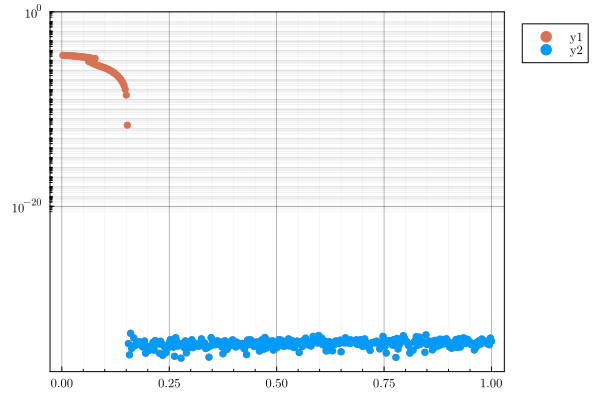

In [46]:
scatter(ρscalc,lsqsolobjs,yscale=:log10,ylim=(1e-37,1e0))
scatter!(ρscalc[solinds],lsqsolobjs[solinds],yscale=:log10,ylim=(1e-37,1e0))

In [47]:
struct SimRes
    ϕN::Float64
    ϕR::Float64
    eN::Float64
    eR::Float64
    qN::Float64
    qR::Float64
    SimRes(sim_data::Vector{Vector{Float64}},S::Int64,M::Int64,ϕNtol::Float64,ϕRtol::Float64) = new(
        (Y->mean((X->mean(X[1:S] .> ϕNtol)).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end] .> ϕRtol)).(Y)))(sim_data),
        (Y->mean((X->mean(X[1:S])).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end])).(Y)))(sim_data),
        (Y->mean((X->mean(X[1:S].^2)).(Y)))(sim_data),
        (Y->mean((X->mean(X[(end-M+1):end].^2)).(Y)))(sim_data)
    )
end

struct RS
    ϕN::Float64
    ϕR::Float64
    ν::Float64
    χ::Float64
    eN::Float64
    eR::Float64
    qN::Float64
    qR::Float64
    RS(lsq_data) = new(lsq_data...)
end

In [48]:
sr=(X->SimRes(X,S,M,10^(-2.2),10^(-2.8))).(sim_results);
rs = (X->RS(X)).(dat);

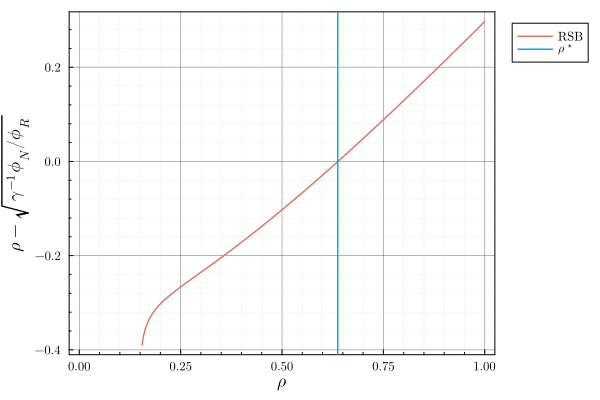

In [49]:
σc = 2e-1sqrt(M);
σe = 2e-1sqrt(M);
γ = M/S;
ρstar =ρscalc[findmin([((X,ρ) -> abs(ρ - sqrt(X.ϕN/(X.ϕR*γ))))(rs[i],ρscalc[i]) for i in eachindex(rs)])[end]]
# let tol = 1e-10
    plot(ρscalc[solinds],[((X,ρ) -> (ρ - sqrt(X.ϕN/(X.ϕR*γ))))(rs[i],ρscalc[i]) for i in eachindex(rs)][solinds],label="RSB")
    # plot!(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> (ρ^2*X.ϕR - X.ϕN/γ))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot!(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> ρ^2*X.χ^2*(1-X.ν*ρ*σc*σe/γ)^2 -X.ϕN*X.ϕR/γ)(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕR*((1+2ρ^2)*X.ϕN/γ-X.ϕR*(ρ^2 * X.ϕR)))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    plot!(ylabel=L"\rho - \sqrt{\gamma^{-1}\phi_N/\phi_R}",xlabel=L"\rho")
    vline!([ρstar],label=L"\rho^\star",xlim=(-0.025,1.025))
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> ρ - (γ*X.ϕR/X.ϕN - 2)^(-1/2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol],label="RSB")
    # plot!(ylabel=L"\rho^2 \phi_R - (1 + 2 \rho^2)\gamma^{-1}\phi_N",xlabel=L"\rho")
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕN*X.ϕR/γ - ρ^2 * X.χ^2*(1-(X.ϕN/(X.χ*γ))^2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol])
    # plot(ρscalc[lsqsolobjs .< tol],[((X,ρ) -> X.ϕN*X.ϕR-ρ^2 * X.χ^2*(1-(X.ν*ρ*σc*σe/γ)^2))(rs[i],ρscalc[i]) for i in eachindex(rs)][lsqsolobjs .< tol])
# end

In [50]:
cat_all_N_results = vcat([vcat((Y -> Y[1:S]).(X)...) for X in sim_results]...);
cat_all_R_results = vcat([vcat((Y -> Y[(end-M+1):end]).(X)...) for X in sim_results]...);
cat_all_results = vcat([vcat((Y -> Y[:]).(X)...) for X in sim_results]...);

In [51]:
# quantile(filter(>(0),cat_all_results),0.2)
sum(cat_all_results .< 1e-350)/size(cat_all_results,1)

0.015978553921568626

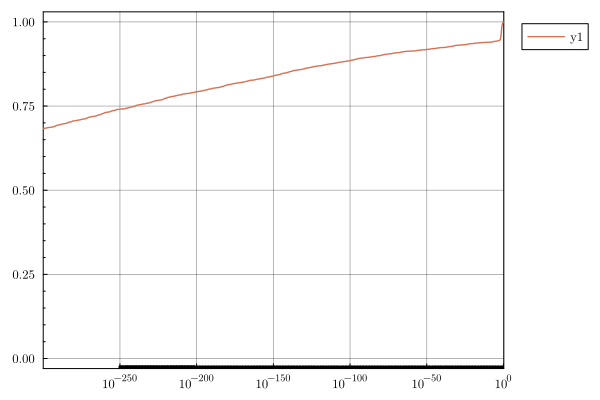

In [52]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(0),cat_all_results))[1:5000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
    xlim=(1e-300,:auto),
#     yscale=:log10,
    xticks=10. .^ (-300:50:0),
    minorgrid=:none
)

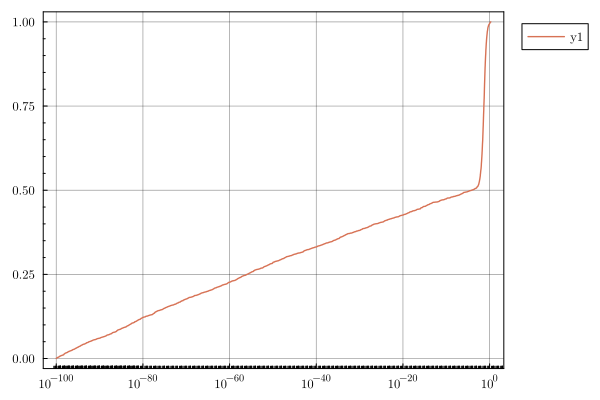

In [53]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-100),cat_all_results))[1:4000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
#     yscale=:log10,
    xticks=10. .^ (-100:20:0),
    minorgrid=:none
)

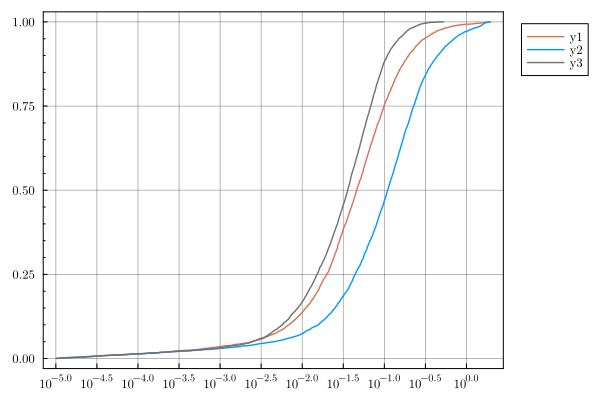

In [54]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_results))[1:5000]);
cat_all_N_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_N_results))[1:5000]);
cat_all_R_results_trunc_sort = sort(shuffle(filter(>(1e-5),cat_all_R_results))[1:5000]);
plot(cat_all_results_trunc_sort,(1:size(cat_all_results_trunc_sort,1))./size(cat_all_results_trunc_sort,1),
    xscale=:log10,
#     yscale=:log10,
    xticks=10. .^ (-10:0.5:0),
    minorgrid=:none
)
plot!(cat_all_N_results_trunc_sort,(1:size(cat_all_N_results_trunc_sort,1))./size(cat_all_N_results_trunc_sort,1))
plot!(cat_all_R_results_trunc_sort,(1:size(cat_all_R_results_trunc_sort,1))./size(cat_all_R_results_trunc_sort,1))

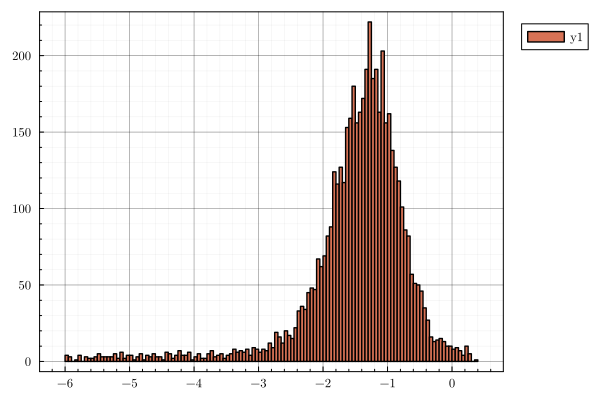

In [55]:
cat_all_results_trunc_sort = sort(shuffle(filter(>(1e-6),cat_all_results))[1:5000]);
histogram(log10.(cat_all_results_trunc_sort),bins=200)

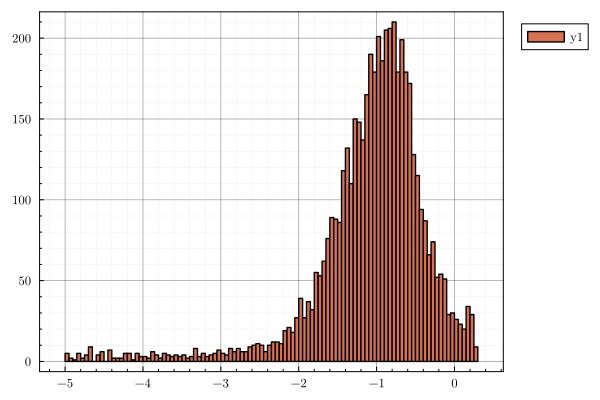

In [56]:
histogram(log10.(cat_all_N_results_trunc_sort),bins=200)


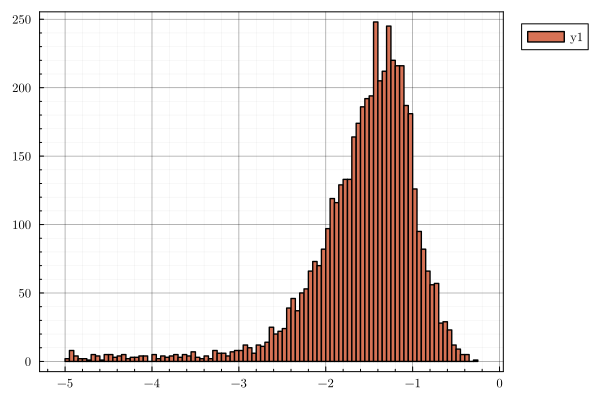

In [57]:
histogram(log10.(cat_all_R_results_trunc_sort),bins=200)

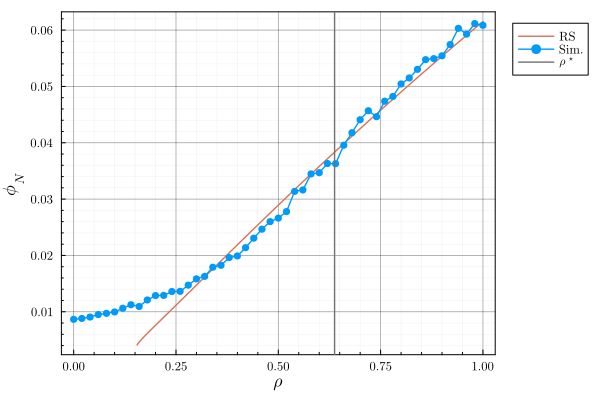

In [109]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕN).(rs)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


In [201]:
# matchingsol_ρs = vcat(((X -> ρscalc[solinds][X .∈ ρscalc[solinds]]).(ρsdat))...);
# matching_indices=sum(((X->(X .∈ ρscalc[solinds])).(matchingsol_ρs))) .> 0;
matching_calc_indices=BitVector(sum((X -> X .∈ ρscalc[solinds]).(ρsdat)));
matching_dat_indices=BitVector(sum((X -> X .∈ ρsdat).(ρscalc[solinds])));

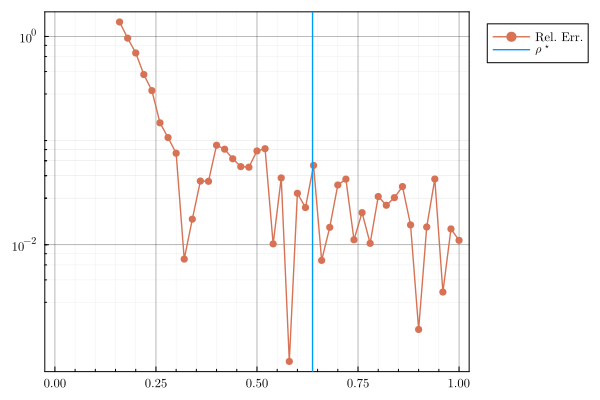

In [236]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.ϕN).(sr)[matching_dat_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,yscale=:log10,xlim=(-0.025,1.025))
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


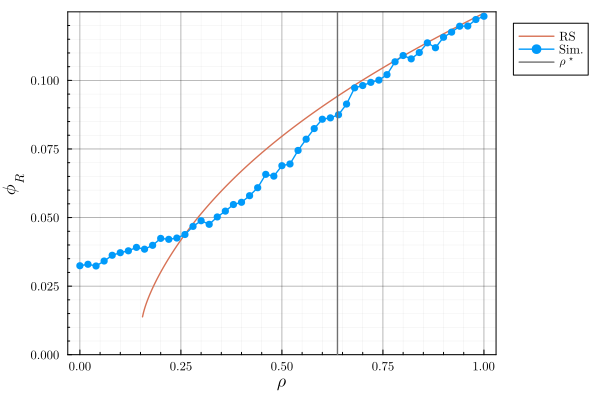

In [108]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕR).(rs)[solinds],ylim=(0,0.125),label="RS",ylabel=L"\phi_R",xlabel=L"\rho")
plot!(ρsdat,(X->X.ϕR).(sr),label="Sim.",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end] .> 10^(-2.8))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


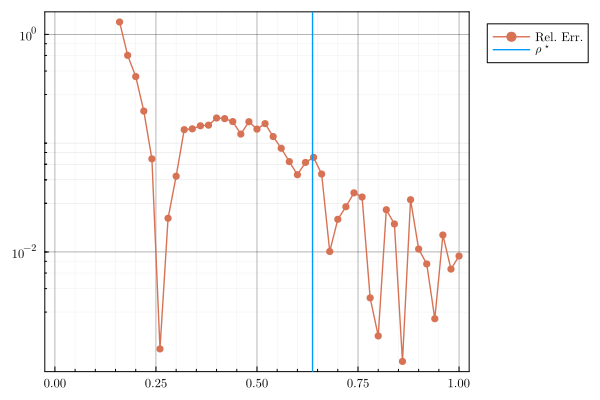

In [235]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.ϕR).(sr)[matching_dat_indices],(X->X.ϕR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,xlim=(-0.025,1.025),yscale=:log10)
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


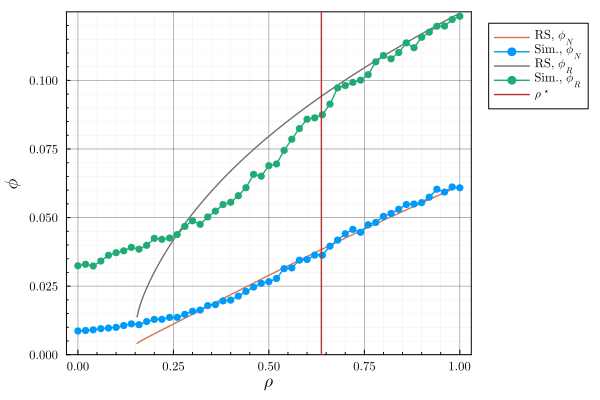

In [141]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot(ρscalc[solinds],(X->X.ϕN).(rs)[solinds],ylabel=L"\phi",xlabel=L"\rho",label=L"RS, $\phi_N$")
plot!(ρsdat,(X->X.ϕN).(sr),label=L"Sim., $\phi_N$",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
plot!(ρscalc[solinds],(X->X.ϕR).(rs)[solinds],ylim=(0,0.125),label=L"RS, $\phi_R$",xlabel=L"\rho")
plot!(ρsdat,(X->X.ϕR).(sr),label=L"Sim., $\phi_R$",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end] .> 10^(-2.8))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


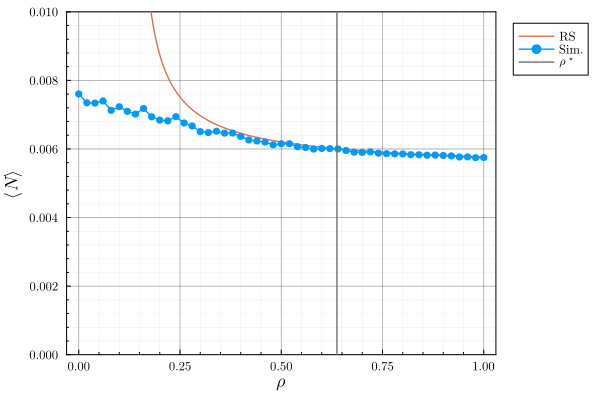

In [107]:
plot(ρscalc[solinds],(X->X.eN).(rs)[solinds],ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# plot(ρscalc,(X->X[5]).(dat),ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S])).(Y))).(sim_results),label="Sim.")
plot!(ρsdat,(X->X.eN).(sr),label="Sim.",marker=:circle)
vline!([ρstar],label=L"\rho^\star")


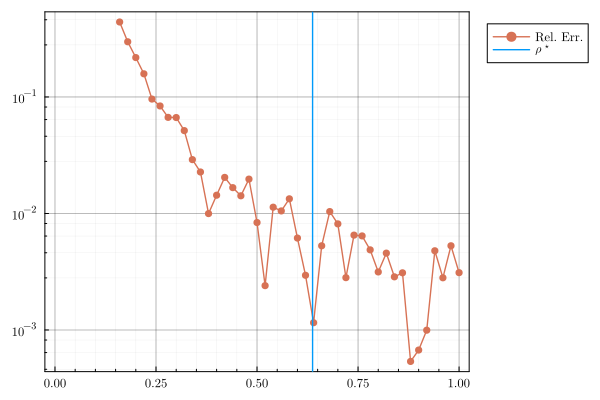

In [237]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.eN).(sr)[matching_dat_indices],(X->X.eN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,yscale=:log10,xlim=(-0.025,1.025))
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


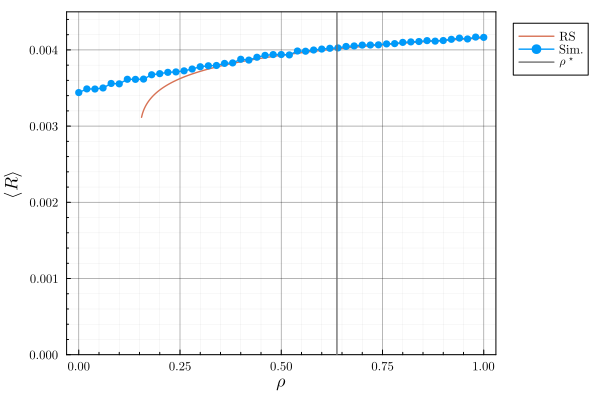

In [105]:
plot(ρscalc[solinds],(X->X.eR).(rs)[solinds],ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.eR).(sr),label="Sim.",ylim=(0,0.0045),marker=:circle)
# plot(ρscalc,(X->X[6]).(dat),ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end])).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")




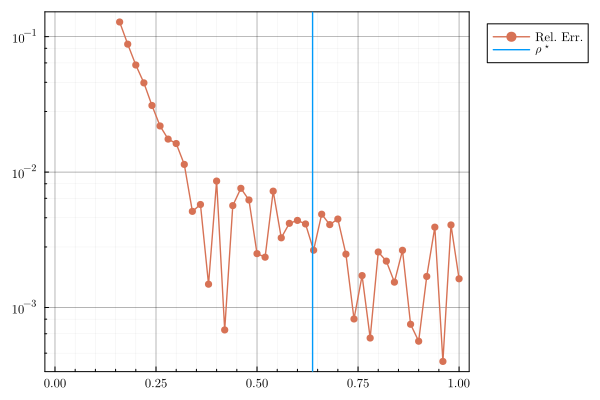

In [238]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.eR).(sr)[matching_dat_indices],(X->X.eR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,yscale=:log10,xlim=(-0.025,1.025))
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


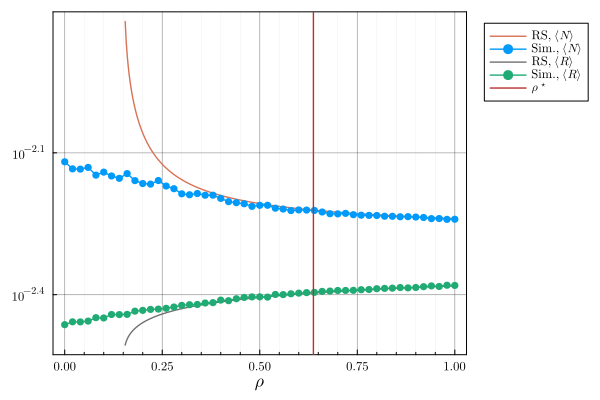

In [156]:
plot(ρscalc[solinds],(X->X.eN).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle N \rangle$")
# plot(ρscalc,(X->X[5]).(dat),ylabel=L"\langle N\rangle",ylim=(0,0.01),xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S])).(Y))).(sim_results),label="Sim.")
plot!(ρsdat,(X->X.eN).(sr),label=L"Sim., $\langle N \rangle$",marker=:circle)
plot!(ρscalc[solinds],(X->X.eR).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle R \rangle$")
plot!(ρsdat,(X->X.eR).(sr),label=L"Sim., $\langle R \rangle$",marker=:circle,yscale=:log10)
# plot!(ρsdat,(X->X.eR).(sr),label=L"Sim., $\langle R \rangle$",marker=:circle,ylim=(0,0.01))
vline!([ρstar],label=L"\rho^\star")
# plot(ρscalc,(X->X[6]).(dat),ylabel=L"\langle R\rangle",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[(end-M+1):end])).(Y))).(sim_results),label="Sim.")



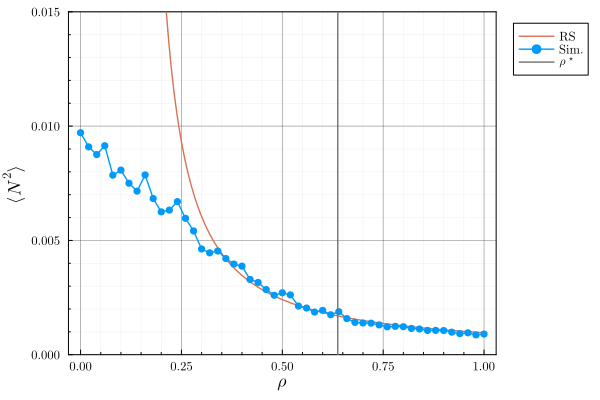

In [103]:
plot(ρscalc[solinds],(X->X.qN).(rs)[solinds],ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
# plot(ρscalc,(X->X[7]).(dat),ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
plot!(ρsdat,(X->X.qN).(sr),label="Sim.",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S].^2)).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


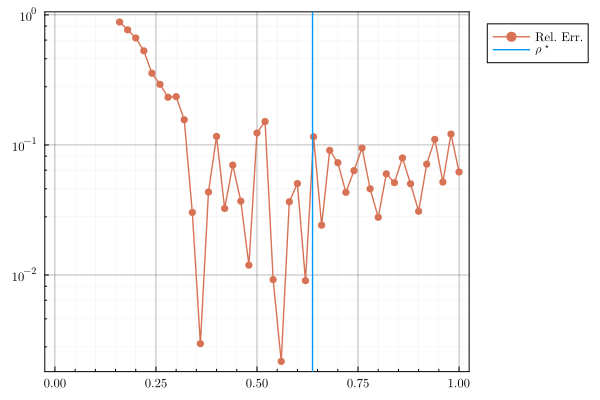

In [239]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.qN).(sr)[matching_dat_indices],(X->X.qN).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,yscale=:log10,xlim=(-0.025,1.025))
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


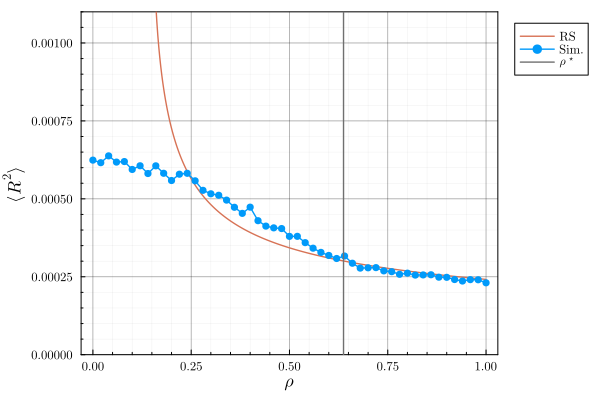

In [151]:
plot(ρscalc[solinds],(X->X.qR).(rs)[solinds],ylim=(0,0.0011),ylabel=L"\langle R^2\rangle",xlabel=L"\rho",label="RS")
plot!(ρsdat,(X->X.qR).(sr),label="Sim.",marker=:circle)
vline!([ρstar],label=L"\rho^\star")



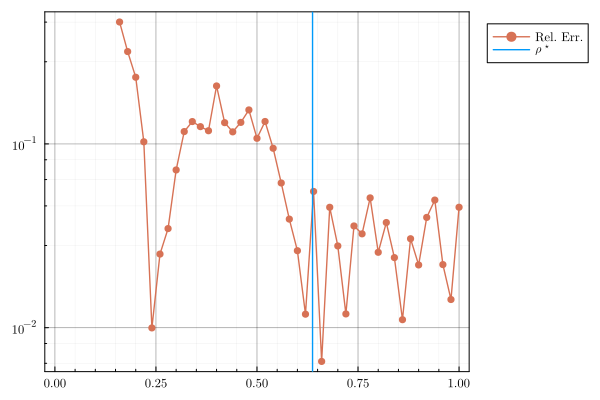

In [240]:
# (ϕN,ϕR,ν,χ,eN,eR,qN,qR)
# plot(ρscalc[solinds][matching_calc_indices],(X->X.ϕN).(rs)[solinds][matching_calc_indices],ylabel="rel. err.",xlabel=L"\rho",label="RS")
plot(ρsdat[matching_dat_indices],((A,B) -> abs.(A.-B)./B)((X->X.qR).(sr)[matching_dat_indices],(X->X.qR).(rs)[solinds][matching_calc_indices]),label="Rel. Err.",marker=:circle,yscale=:log10,xlim=(-0.025,1.025))
# plot!(ρsdat,(X->X.ϕN).(sr),label="Sim.",marker=:circle)
# plot(ρscalc[solinds],(X->X[1]).(dat)[solinds],ylabel=L"\phi_N",xlabel=L"\rho",label="RS")
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S] .> 10^(-2.2))).(Y))).(sim_results),label="Sim.")
vline!([ρstar],label=L"\rho^\star")


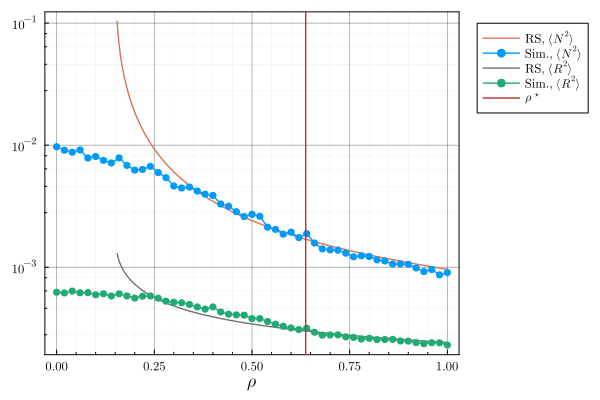

In [155]:
plot(ρscalc[solinds],(X->X.qN).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle N^2\rangle$")
# plot(ρscalc,(X->X[7]).(dat),ylabel=L"\langle N^2\rangle",xlabel=L"\rho",label="RS",ylim=(0,0.015))
plot!(ρsdat,(X->X.qN).(sr),label=L"Sim., $\langle N^2\rangle$",marker=:circle)
# scatter!(ρsdat,(Y->mean((X->mean(X[1:S].^2)).(Y))).(sim_results),label="Sim.")
# vline!([ρstar],label=L"\rho^\star")
plot!(ρscalc[solinds],(X->X.qR).(rs)[solinds],xlabel=L"\rho",label=L"RS, $\langle R^2\rangle$")
plot!(ρsdat,(X->X.qR).(sr),label=L"Sim., $\langle R^2\rangle$",marker=:circle,yscale=:log10)#ylim=(0,0.015)
vline!([ρstar],label=L"\rho^\star")



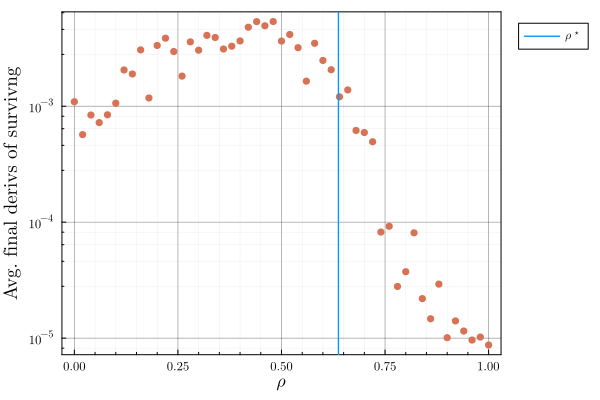

In [241]:
# scatter(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 1e-3])) for i in 1:160]) for ρi in eachindex(ρsdat)])
scatter(ρsdat,(Y->mean((X->sum(abs.(X))).(Y))).(deriv_sim_results),label=:none,xlabel=L"\rho",ylabel="Avg. final derivs of survivng",yscale=:log10)

vline!([ρstar],label=L"\rho^\star")



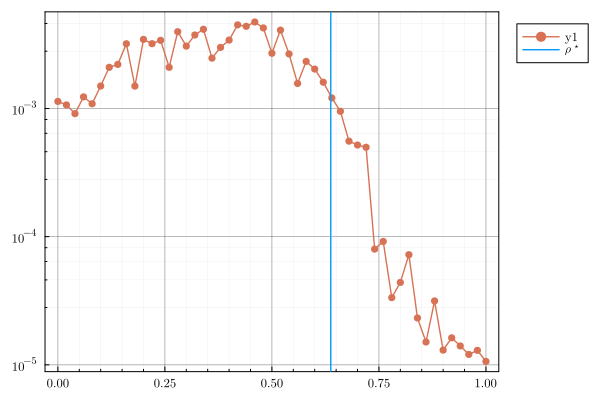

In [257]:
plot(ρsdat,[mean([mean(abs.(deriv_sim_results[ρi][i][sim_results[ρi][i] .> 10^(-2.5)]./filter(>(10^(-2.5)),sim_results[ρi][i]))) for i in 1:160]) for ρi in eachindex(ρsdat)],
yscale=:log10,
marker=:circle
)
vline!([ρstar],label=L"\rho^\star")


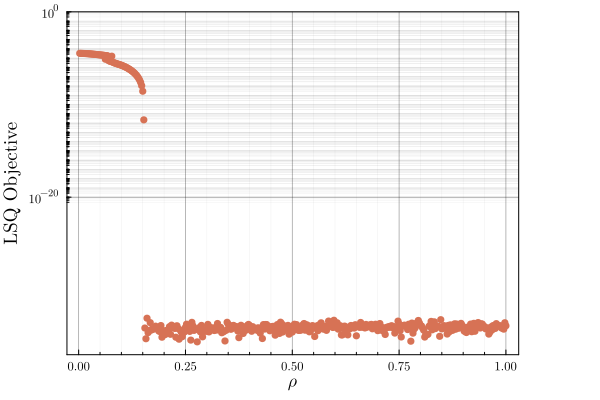

In [249]:
scatter(ρscalc,lsqsolobjs,yscale=:log10,ylim=(1e-37,1e0),ylabel="LSQ Objective",xlabel=L"\rho",label=:none)
